# Classifying Earthquakes
In this notebook, I classify earthquakes using an LSTM RNN TensorFlow model. The data is taken from the [UCR Time Series Classification Archive](http://www.cs.ucr.edu/~eamonn/time_series_data/) (Yanping Chen, Eamonn Keogh, Bing Hu, Nurjahan Begum, Anthony Bagnall, Abdullah Mueen and Gustavo Batista (2015)).

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow.python.framework import ops
from matplotlib import pyplot as plt
from natsort import natsorted
%matplotlib inline

## Data Preparation
### Load the Data
I load the data into Pandas DataFrames.

In [2]:
training_set = pd.read_csv('data/Earthquakes_TRAIN', sep=',')
test_validation_set = pd.read_csv('data/Earthquakes_TEST', sep=',')

In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Columns: 513 entries, 0 to -0.26927.475
dtypes: float64(512), int64(1)
memory usage: 553.2 KB


In [4]:
training_set.iloc[:,0].unique()

array([1, 0])

## Data Exploration
Let's separate the labels and features from both the training set and test/validation set. I can then investigate trends for each data set.

In [5]:
X_train = training_set.iloc[:,1:]
y_train = training_set.iloc[:,0]

In [6]:
X_test_validation = test_validation_set.iloc[:,1:]
y_test_validation = test_validation_set.iloc[:,0]

In [7]:
unique_training_classes =  y_train.unique().tolist()
print("There are {} unique training classes, which are {}.".format(len(unique_training_classes), unique_training_classes))

There are 2 unique training classes, which are [1, 0].


In [8]:
unique_test_validation_classes =  y_test_validation.unique().tolist()
print("There are {} unique test classes, which are {}.".format(len(unique_test_validation_classes), unique_test_validation_classes))

There are 2 unique test classes, which are [0, 1].


Good, all classes in the training and test sets are in agreement, as expected. Now, let's investigate the number of unique classes for each data set.

In [9]:
print("In the training set, there are {} '0' classes and {} '1' classes.".format(len(y_train[y_train == 0]), len(y_train[y_train == 1])))

In the training set, there are 103 '0' classes and 35 '1' classes.


In [10]:
print("In the test/validation set, there are {} '0' classes and {} '1' classes.".format(len(y_test_validation[y_test_validation == 0]), len(y_test_validation[y_test_validation == 1])))

In the test/validation set, there are 264 '0' classes and 57 '1' classes.


There is an unequal number of entries between the two different classes. This could be problematic during the modeling phase as it could lead to a bias. I will address this issue duing data preparation below.

### Data Visualization
Let's plot a row of the training set and view what the data looks like.

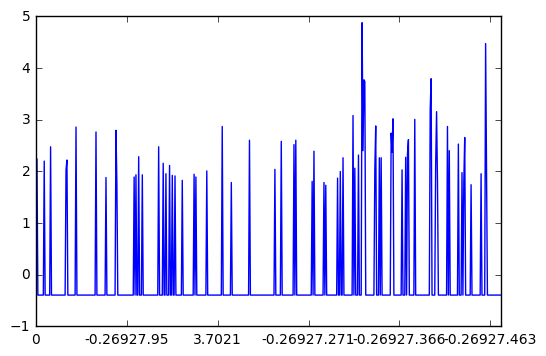

In [11]:
mask = training_set.iloc[:,0] == 0
subset = training_set.ix[mask == True, :].copy()
subset.iloc[0,:].plot()

## Data Preparation
### Evenly split labels.
Here I define a function to randomly choose values from the larger of the two classes and produce a dataset with equal quantities of both classes. This will be done for both the train set and test set.

In [12]:
def random_data_split(df):
    
    classes = df.iloc[:,0]
    unique_classes = classes.unique()
    
    number_of_classes_list = []
    for c in unique_classes:
        number_of_classes = len(classes[classes == c])
        number_of_classes_list.append(number_of_classes)
        
    smallest_class_index = np.argmin(np.array(number_of_classes_list))
    smallest_class = unique_classes[smallest_class_index]
    
    # Store smallest class in a DataFrame
    smallest_class_mask = (df.iloc[:,0] == smallest_class).tolist()
    df_small = df.iloc[smallest_class_mask,:]
    smallest_class_size = len(df_small)
    
    # Select only classes larger than the smallest class
    larger_classes = unique_classes[unique_classes != smallest_class]
    larger_classes_mask = (df.iloc[:,0] != smallest_class).tolist()
    df_larger = df.iloc[larger_classes_mask,:]
    
    # Loop through the larger classes and select a random set of size equal to the smallest class size
    for lc in larger_classes:
        class_mask = (df_larger.iloc[:,0] == lc).tolist()
        df_get_class = df_larger.iloc[class_mask,:]
        df_sample = df_get_class.sample(n=smallest_class_size)
        df_small = df_small.append(df_sample)
    
    return df_small

In [13]:
training_set_resampled = random_data_split(training_set)
new_training_index = np.arange(len(training_set_resampled))
training_set_resampled = training_set_resampled.set_index(new_training_index).copy()

In [14]:
y_training_resampled = training_set_resampled.iloc[:,0]
unique_training_labels_resampled = y_training_resampled.unique()

for c in unique_training_labels_resampled:
    label_count = len(y_training_resampled[y_training_resampled == c])
    print('There are {} entries for class {} in the training set.'.format(label_count, c))

There are 35 entries for class 1 in the training set.
There are 35 entries for class 0 in the training set.


In [15]:
test_validation_set_resampled = random_data_split(test_validation_set)
new_test_validation_index = np.arange(len(test_validation_set_resampled))
test_validation_set_resampled = test_validation_set_resampled.set_index(new_test_validation_index).copy()

In [16]:
y_test_validation_resampled = test_validation_set_resampled.iloc[:,0]
unique_test_validation_labels_resampled = y_test_validation_resampled.unique()

for c in unique_test_validation_labels_resampled:
    label_count = len(y_test_validation_resampled[y_test_validation_resampled == c])
    print('There are {} entries for class {} in the test/validation set.'.format(label_count, c))

There are 57 entries for class 1 in the test/validation set.
There are 57 entries for class 0 in the test/validation set.


Good. Now I have a way to ensure that each class is represented equally in the analysis.

### Split test_validation_set into test_set and validation_set
Now I split the test_validation_set equally into a test_set and validation_set. The validation_set will be used to test the model accuracy during training, while the test_set will be used to measure the final model accuracy.

In [17]:
split_index = len(test_validation_set_resampled) // 2
test_set_resampled = test_validation_set_resampled.iloc[0:split_index,:].copy()
validation_set_resampled = test_validation_set_resampled.iloc[split_index:,:].copy()
new_validation_set_resampled_index = np.arange(len(validation_set_resampled))
validation_set_resampled = validation_set_resampled.set_index(new_validation_set_resampled_index).copy()

## Model Preparation

In [18]:
# Function to take a random batch of data from the training set
def make_batch(full_training_set, batch_size, back_prop_steps):
    
    num_rows, num_columns = full_training_set.shape
    
    bp_start_i = np.random.choice(num_columns-back_prop_steps,1)[0]
    bp_end_i = bp_start_i + back_prop_steps
    
    random_batch = full_training_set.sample(n=batch_size)
    
    X_batch = random_batch.iloc[0:,bp_start_i:bp_end_i]
    y_batch_array = random_batch.iloc[:,0].values
    y_batch = np.array([y_batch_array]*back_prop_steps)
    
    return X_batch, y_batch

In [19]:
# Function to print hyperparameters to a directory
def save_hyperparameters(hyperparam_dict, training_step_list, final_accuracy):
    
    cwd = os.getcwd()
    fpath = cwd+'/tmp/params'
    try:
        dirlist = os.listdir(fpath)
        dirlist_parsed = [x.split('_') for x in dirlist]
        dirlist_parsed_prefix = [x.split('_')[0] for x in dirlist]
        dirlist_parsed_suffix = [x.split('_')[-1] for x in dirlist]

        dirarray = np.array(dirlist)
        dirarray_parsed_prefix = np.array(dirlist_parsed_prefix)
        dirarray_sorted_suffix = np.array(natsorted(dirlist_parsed_suffix))
    
        num_run_dirs = np.sum(dirarray_parsed_prefix == 'run')
    
    except FileNotFoundError:
        os.mkdir(fpath)
        num_run_dirs = 0

    # Check if run_1 directory exisits
    if num_run_dirs == 0:
        next_run_directory = '/run_1'
    else:
        previous_run_number = np.int(dirarray_sorted_suffix[-1])
        next_run = previous_run_number + 1
        next_run_string = np.str(next_run)
        next_run_directory = '/run_'+next_run_string
        
    os.mkdir(fpath+next_run_directory)    
    fo = open(fpath+next_run_directory+'/hyperparameters.txt', "w")
    for key, value in hyperparam_dict.items():
        fo.write(key+': '+np.str(value)+'\n')
    fo.write('\n')
    for list_item in training_step_list:
        fo.write(list_item+'\n')
    fo.write("The final accuracy is {:3f}.".format(final_accuracy))
    fo.close()
    
    print('Saving hyperparameters to tmp/params{}/'.format(next_run_directory))

In [20]:
# Function to print parameters to a directory
def create_log_directory():
    
    cwd = os.getcwd()
    fpath = cwd+'/tmp/logs'
    try:
        dirlist = os.listdir(fpath)
        dirlist_parsed = [x.split('_') for x in dirlist]
        dirlist_parsed_prefix = [x.split('_')[0] for x in dirlist]
        dirlist_parsed_suffix = [x.split('_')[-1] for x in dirlist]

        dirarray = np.array(dirlist)
        dirarray_parsed_prefix = np.array(dirlist_parsed_prefix)
        dirarray_sorted_suffix = np.array(natsorted(dirlist_parsed_suffix))
    
        num_run_dirs = np.sum(dirarray_parsed_prefix == 'run')
    
    except FileNotFoundError:
        os.mkdir(fpath)
        num_run_dirs = 0

    # Check if run_1 directory exisits
    if num_run_dirs == 0:
        os.mkdir(fpath+'/run_1')
        log_directory = 'tmp/logs/run_1'
    else:
        previous_run_number = np.int(dirarray_sorted_suffix[-1])
        next_run = previous_run_number + 1
        next_run_string = np.str(next_run)
        next_run_directory = '/run_'+next_run_string
        os.mkdir(fpath+next_run_directory)
        log_directory = 'tmp/logs/run_'+next_run_string

    print('Saving summaries to '+log_directory+'/')    
        
    return log_directory

### Define the hyperparameters
Organized in dictionary to allow easy logging of values while searching for best model parameters.

In [21]:
# Define the hyperparameters
hyperparam_dict = dict(
    number_of_classes = len(unique_training_labels_resampled),
    batch_size = 10,
    back_prop_steps = 50,
    lstm_layers = 2,
    lstm_cell_units = 7,
    drop_out = 0.8,
    clipping_ratio = 5,
    learning_rate = 2e-6,
    training_iterations = 2000
)

In [22]:
# Define TensorFlow placeholders
X = tf.placeholder(tf.float32,
                   [None, hyperparam_dict['back_prop_steps']],
                   name = 'Features')
y = tf.placeholder(tf.int64,
                   [None, hyperparam_dict['back_prop_steps']], 
                   name='Labels')
keep_probability = tf.constant(hyperparam_dict['drop_out'])

# Expand dimensions of features placeholder
X_expanded = tf.expand_dims(X, 2)

# Reshaped labels placeholder
y_reshaped = tf.reshape(y, [-1])

### Create the LSTM cell
This includes dropout and multiple layers.

In [23]:
def create_lstm_cell(lstm_cell_units, keep_probability, lstm_layers, batch_size, X):
    cell = tf.nn.rnn_cell.LSTMCell(lstm_cell_units, state_is_tuple=True)
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_probability)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * lstm_layers, state_is_tuple=True)
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_probability)
    init_state = cell.zero_state(batch_size, tf.float32)
    cell_outputs, state = tf.nn.dynamic_rnn(cell, X, initial_state=init_state)
    cell_outputs = tf.reshape(cell_outputs, [-1, lstm_cell_units])
    
    return cell_outputs, state

### Create the softmax layer
The LSTM cells will be placed in a softmax layer. This will allow the RNN to learn categorical data.

In [24]:
def softmax_layer(lstm_cell_units, number_of_classes, cell_outputs):
    W = tf.Variable(tf.truncated_normal([lstm_cell_units, number_of_classes], 
                                        stddev=1.0), 
                    name='weights', dtype=tf.float32, trainable=True)
    b = tf.Variable(tf.zeros([number_of_classes]), 
                    name='biases', dtype=tf.float32, trainable=True)
    logits = tf.add(tf.matmul(cell_outputs, W, name='multiply'), b, name='add')
    
    return logits

### Define the cost function

In [25]:
def define_cost_function(logits, y, batch_size):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y, 
                                                          name='cross_entropy')
    cost = tf.reduce_mean(loss) / batch_size
    
    return cost

### Create the training step

In [26]:
def train(cost, learning_rate, clipping_ratio):
    training_variables = tf.trainable_variables()
    computed_gradientes = tf.gradients(cost, training_variables)
    clipped_gradients, _ = tf.clip_by_global_norm(computed_gradientes, 
                                                  clipping_ratio)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = list(zip(clipped_gradients, training_variables))
    training_step = optimizer.apply_gradients(gradients)
    # Create histograms for variables, gradients and gradient norms. Plots displayed in TensorBoard.
    for gradient, variable in gradients:
        if isinstance(gradient, ops.IndexedSlices):
            gradient_values = gradient.values
        else:
            gradient_values = gradient
        tf.histogram_summary(variable.name, variable)
        tf.histogram_summary(variable.name + "/gradients", gradient_values)
        tf.histogram_summary(variable.name + "/gradient_norm", 
                             tf.global_norm([gradient_values]))

    return training_step

### Check model accuracy during training

In [27]:
def check_model_accuracy(logits, y):
    correct_prediction = tf.equal(tf.argmax(logits,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"), 
                              name='accuracy')
    
    return accuracy

### Compute the final model accuracy

In [28]:
# Function to compute final model accuracy
def compute_final_accuracy(test_set, batch_size, back_prop_steps):
    test_rows = test_set.shape[0]
    number_of_batches = np.floor(test_rows/batch_size)
    test_accuracy = np.zeros(number_of_batches)
    for i in range(int(number_of_batches)):
        X_batch, y_batch = make_batch(test_set, batch_size, back_prop_steps)
        X_batch_expanded = np.expand_dims(X_batch, axis=2)
        y_batch_reshaped = np.ravel(y_batch)
        test_accuracy[i] = sess.run(accuracy, 
                                    feed_dict = {X_expanded: X_batch_expanded, 
                                                 y_reshaped: y_batch_reshaped,
                                                 keep_probability: 1})
    
    return np.mean(test_accuracy)

## Setup the TensorFlow Graph
Now that we have defined the functions needed for the TensorFlow graph, we can create it.

In [29]:
# Create LSTM Cell
with tf.name_scope("LSTM") as scope:
    cell_outputs, state = create_lstm_cell(hyperparam_dict['lstm_cell_units'], 
                                           keep_probability, 
                                           hyperparam_dict['lstm_layers'], 
                                           hyperparam_dict['batch_size'], 
                                           X_expanded)

# Create softmax layer
with tf.name_scope("softmax_layer") as scope:
    logits = softmax_layer(hyperparam_dict['lstm_cell_units'], 
                           hyperparam_dict['number_of_classes'], 
                           cell_outputs)

# Define cost function
with tf.name_scope("cost_function") as scope:
    cost = define_cost_function(logits, 
                                y_reshaped, 
                                hyperparam_dict['batch_size'])
    tf.scalar_summary("cost", cost)

# Define training step
with tf.name_scope("training") as scope:
    training_step = train(cost, 
                          hyperparam_dict['learning_rate'], 
                          hyperparam_dict['clipping_ratio'])

# Calculate model accuracy
with tf.name_scope("accuracy") as scope:
    accuracy = check_model_accuracy(logits, y_reshaped)
    tf.scalar_summary("accuracy", accuracy)

## Train the model

In [30]:
# Merge summaries for TensorBoard
merged_summaries = tf.merge_all_summaries()

# Start a TensorFlow session
with tf.Session() as sess:
    
    log_directory = create_log_directory()
    summary_writer = tf.train.SummaryWriter(log_directory, sess.graph)
    
    tf.initialize_all_variables().run()

    step = 0
    training_step_list = []
    cost_train_ma = -np.log(1/float(hyperparam_dict['number_of_classes'])+1e-9)
    training_set_resampled = random_data_split(training_set)
    training_set_size = training_set_resampled.shape[0]
    resample_frequency = hyperparam_dict['training_iterations'] // training_set_size
    print("Training set resampled every {} steps.".format(resample_frequency))
    for i in range(hyperparam_dict['training_iterations']):
        # Generate a new training set for a given frequency
        if i % resample_frequency == 0:
            training_set_resampled = random_data_split(training_set)
            new_training_index = np.arange(len(training_set_resampled))
            training_set_resampled = training_set_resampled.set_index(new_training_index).copy()

        # Sample batch for training
        X_batch, y_batch = make_batch(training_set_resampled, 
                                      hyperparam_dict['batch_size'], 
                                      hyperparam_dict['back_prop_steps'])
        X_batch_expanded = np.expand_dims(X_batch, axis=2)
        y_batch_reshaped = np.ravel(y_batch)

        # Train the model
        cost_train, _ = sess.run([cost, training_step], 
                                 feed_dict = {X_expanded:X_batch_expanded, 
                                              y_reshaped:y_batch_reshaped, 
                                              keep_probability: hyperparam_dict['drop_out']}
                                )
        cost_train_ma = cost_train_ma*0.99 + cost_train*0.01
        if i%100 == 0:

            # Evaluate validation performance
            X_batch, y_batch = make_batch(validation_set_resampled, 
                                          hyperparam_dict['batch_size'], 
                                          hyperparam_dict['back_prop_steps'])
            X_batch_expanded = np.expand_dims(X_batch, axis=2)
            y_batch_reshaped = np.ravel(y_batch)
            result = sess.run([cost, merged_summaries, accuracy], 
                              feed_dict = {X_expanded: X_batch_expanded, 
                                           y_reshaped: y_batch_reshaped,
                                           keep_probability: 1},
                             )
            cost_validation = result[0]
            accuracy_validation = result[2]
            # cost_validation = cost
            # accuracy_validation = acc
            training_step_stats = 'Step {:d} of {:d}: training cost = {:0.3f}, validation cost = {:0.3f}, validation accuracy = {:0.3f}.'.format(i,hyperparam_dict['training_iterations'],cost_train,cost_validation,accuracy_validation)
            print(training_step_stats)
            training_step_list.append(training_step_stats)

            # Save model parametes for TensorBoard
            summary_str = result[1]
            summary_writer.add_summary(summary_str, i)
            summary_writer.flush()

            step += 1

    final_accuracy = compute_final_accuracy(test_set_resampled, 
                                            hyperparam_dict['batch_size'], 
                                            hyperparam_dict['back_prop_steps'])
    print("The final accuracy is {:3f}.".format(final_accuracy))
    
    # Save hyperparameters used for model fitting
    save_hyperparameters(hyperparam_dict, training_step_list, final_accuracy)

Saving summaries to tmp/logs/run_78/
Training set resampled every 28 steps.
Step 0 of 2000: training cost = 0.072, validation cost = 0.080, validation accuracy = 0.300.
Step 100 of 2000: training cost = 0.068, validation cost = 0.087, validation accuracy = 0.212.
Step 200 of 2000: training cost = 0.069, validation cost = 0.079, validation accuracy = 0.270.
Step 300 of 2000: training cost = 0.077, validation cost = 0.083, validation accuracy = 0.160.
Step 400 of 2000: training cost = 0.068, validation cost = 0.076, validation accuracy = 0.380.
Step 500 of 2000: training cost = 0.067, validation cost = 0.078, validation accuracy = 0.296.
Step 600 of 2000: training cost = 0.073, validation cost = 0.080, validation accuracy = 0.200.
Step 700 of 2000: training cost = 0.072, validation cost = 0.082, validation accuracy = 0.202.
Step 800 of 2000: training cost = 0.071, validation cost = 0.076, validation accuracy = 0.262.
Step 900 of 2000: training cost = 0.076, validation cost = 0.083, valid

/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The final accuracy is 0.708400.
Saving hyperparameters to tmp/params/run_78/
